### 1. 배경 설정
- 라이브러리 import
- images load ('001_00.png', 'list_train', 'list_test2')

In [1]:
import cv2
import numpy as np
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import math
import random

In [2]:
from glob import glob
from os.path import join

train_path = 'train_ref'
test2_path = 'test2'

list_train = sorted(glob(join(train_path, '*.BMP')))
list_test2 = sorted(glob(join(test2_path, '*.BMP')))
print(len(list_train), len(list_test2))

477 1428


In [3]:
image = cv2.imread("001_00.png", 0)

### 2. 이미지 전처리, 특징 추출
- Box Blur * 2 -> adaptiveThreshold -> morphology -> skeletonize

In [4]:
def filtering(src, kernel, ks):
    filtered = cv2.filter2D(src, -1, kernel)
    return filtered.astype(np.uint8)

def detect_minutiae(skel):
    kernel = np.ones((3, 3), dtype = np.float32)
    row, col = skel.shape
    mask = (skel == 255)
    
    skel_float = skel.astype(np.float32)
    filtered = cv2.filter2D(skel_float, -1, kernel)
    
    endpoints_indices = np.where((filtered == 510) & mask)
    endpoints = np.column_stack(endpoints_indices)

    bifurcations_indices = np.where((filtered == 1020) & mask)
    bifurcations = np.column_stack(bifurcations_indices)

    minutiae = np.concatenate(
        [np.column_stack([endpoints, np.zeros(len(endpoints))]),
         np.column_stack([bifurcations, np.full(len(bifurcations), 255)])]
    )

    return endpoints, bifurcations, minutiae

def excludeBorderPoints(points, image):
    image = np.array(image)
    
    def is_zero_section(start, end, h):
        return np.all(image[h, start+1:end] == 0)
    
    def is_zero_section_for_y(start, end, w):
        return np.all(image[start+1:end, w] == 0)
    
    points = np.array(points)
    
    mask1 = (points[:, 1] <= 127) & (np.vectorize(is_zero_section)(0, points[:, 1], points[:, 0]))
    mask2 = (points[:, 1] > 127) & (np.vectorize(is_zero_section)(points[:, 1], 256, points[:, 0]))
    
    result = points[~(mask1 | mask2)]
    
    mask3 = (result[:, 0] <= 127) & (np.vectorize(is_zero_section_for_y)(0, result[:, 0], result[:, 1]))
    mask4 = (result[:, 0] > 127) & (np.vectorize(is_zero_section_for_y)(result[:, 0], 256, result[:, 1]))
    
    result2 = result[~(mask3 | mask4)]
    
    return result2.tolist()

def mark_minutiae(src, endpoints, bifurcations):
    color_src = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)
    
    for (x, y) in endpoints:
        cv2.circle(color_src, (y, x), 1, (0, 0, 255), 1)  # endpoint 파랑

    for (x, y) in bifurcations:
        cv2.circle(color_src, (y, x), 1, (255, 0, 0), 1)  # intersections 빨강

    return color_src

def get_fp_feature(image, flg_show=True):
    ks = 3
    kernel = np.ones((ks, ks)) / (ks*ks)
    blurred1 = filtering(image, kernel, ks)
    blurred2 = filtering(blurred1, kernel, ks)

    block_size = 9
    C = 5
    blur_bin = cv2.adaptiveThreshold(blurred2, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, C)
    blur_bin = np.max(blur_bin) - blur_bin
    
    morph_blur_bin = cv2.morphologyEx(blur_bin, cv2.MORPH_CLOSE, None)
    
    skeleton0 = skeletonize(morph_blur_bin // 255)
    skeleton = skeleton0.astype(np.uint8) * 255

    end0, bif0, minutiae = detect_minutiae(skeleton)
    end = excludeBorderPoints(end0, skeleton)
    bif = excludeBorderPoints(bif0, skeleton)
    
    if flg_show:
        marked_image = mark_minutiae(skeleton, end, bif)
        
        plt.subplot(2, 2, 1)
        plt.imshow(image, cmap='gray')
        plt.subplot(2, 2, 2)
        plt.imshow(morph_blur_bin, cmap='gray')
        
        plt.subplot(2, 2, 3)
        plt.imshow(skeleton, cmap='gray')
        plt.subplot(2, 2, 4)
        plt.imshow(marked_image, cmap='gray')

    return end, bif, minutiae


35 311
CPU times: user 22.6 ms, sys: 1.41 ms, total: 24 ms
Wall time: 24.2 ms


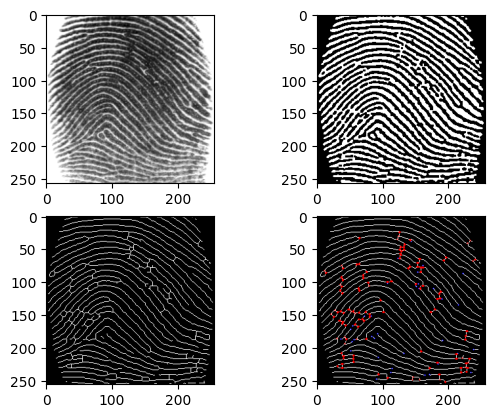

In [5]:
%%time
end, bif, minutiae = get_fp_feature(image, flg_show=True)
print(len(end), len(bif))

### 3. 매칭
- test set의 각 샘플과 동일한 train set 지문 매칭

특징점 저장 형태
- endpoint = 0
- bifurcation = 255

특징점 매칭
- 두 이미지 각각의 특징점 사이의 거리가 threshold보다 가까우면 매칭으로 판단
- 두 이미지를 함께 두고 매칭된 특징점을 시각적으로 확인 가능하도록 제시

매칭 점수
- distance: 매칭점 사이의 거리의 총합
- match_score: (매칭된 포인트 총 개수) / (두 이미지의 특징점 개수 평균)

test2/100_type1.BMP 100 train_ref/100.BMP


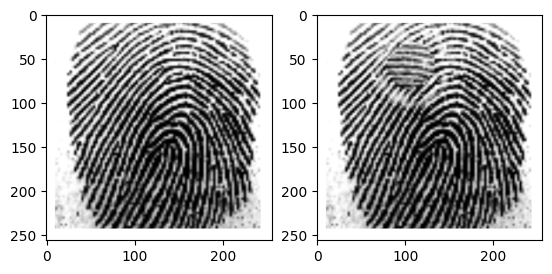

In [6]:
# 이미지 준비
target_path = list_test2[0]
basename = os.path.basename(target_path).split('_')[0]
train_sample_path = join(train_path, basename + '.BMP')
print(target_path, basename, train_sample_path)
img_train = cv2.imread(train_sample_path, 0)
img_test = cv2.imread(target_path, 0)

plt.subplot(121)
plt.imshow(img_train, cmap='gray')
plt.subplot(122)
plt.imshow(img_test, cmap='gray')

In [7]:
def match_finger(A, B, threshold, flg_show=False, img_A=None, img_B=None):
    matches = []
    A = A.astype(np.float64)
    B = B.astype(np.float64)
    dist = 0

    for xA, yA in A:
        distances = np.sqrt(np.sum((B - np.array([xA, yA]))**2, axis=1))
        closest_point_index = np.argmin(distances)
        min_distance = distances[closest_point_index]
        
        if min_distance <= threshold:
            matches.append((xA, yA, B[closest_point_index][0], B[closest_point_index][1]))
            dist += min_distance
        
    match_score = 100 * (len(matches)) / ((len(A) + len(B)) / 2)
    matches = np.array(matches)

    if flg_show:
        img_query = cv2.cvtColor(img_A, cv2.COLOR_GRAY2BGR)
        img_train = cv2.cvtColor(img_B, cv2.COLOR_GRAY2BGR)
        match_img = cv2.hconcat([img_query, img_train])

        for i in range(len(matches)):
            xA = matches[i][0]
            yA = matches[i][1]
            xB = matches[i][2]
            yB = matches[i][3]
            
            pointA = (int(xA), int(yA))
            pointB = (int(xB), int(yB))
            rand_R = random.randint(50, 200)
            rand_G = random.randint(50, 200)
            rand_B = random.randint(50, 200)
            match_color = (rand_R, rand_G, rand_B)

            converted_pointA = (pointA[1], pointA[0])
            converted_pointB = (pointB[1]+256, pointB[0])
            
            cv2.circle(match_img, converted_pointA, 1, match_color, 3)
            cv2.circle(match_img, converted_pointB, 1, match_color, 3)
            cv2.line(match_img, converted_pointA, converted_pointB, match_color, 1)
    
            plt.imshow(match_img)
    
    return dist, match_score

def find_match(query_image, list_train, match_threshold):
    test_end, test_bif, _ = get_fp_feature(query_image, flg_show=False)
    feat_query = np.concatenate([test_end, test_bif]).astype(np.uint8)

    best_score = 0
    best_dist = 0
    best_img = 0
    
    for t in list_train:
        basename = os.path.basename(t)
        img_train2 = cv2.imread(t, 0)
        
        db_x_end, db_x_bif, _ = get_fp_feature(img_train2, False)
        feat_db_x = np.concatenate([db_x_end, db_x_bif]).astype(np.uint8)
        
        dist, match_score = match_finger(feat_query, feat_db_x, match_threshold, False, img_A=None, img_B=None)
        
        if match_score > best_score:
            best_score = match_score
            best_dist = dist
            best_img = basename
            
    return best_img, best_score, best_dist

def calculateAccuracy(pred, label):
    length = len(pred)
    success = []
    fail = []
    for i in range(length):
        if pred[i] == label[i]:
            success.append(i)
        else:
            fail.append(i)
        
    accuracy = 100 * len(success) / (len(success) + len(fail))
    
    print(f"Success: {len(success)} out of {len(pred)}\nAccuracy: {accuracy}")

In [8]:
test_end, test_bif, test_m = get_fp_feature(img_test, flg_show=False)
train_end, train_bif, train_m = get_fp_feature(img_train, flg_show=False)

feat_query = np.concatenate([test_end, test_bif]).astype(np.uint8)
feat_train = np.concatenate([train_end, train_bif]).astype(np.uint8)
print(len(feat_query), len(feat_train))

404 388


distances = 107.48760113441963
match score = 94.44444444444444
CPU times: user 306 ms, sys: 11.9 ms, total: 318 ms
Wall time: 114 ms


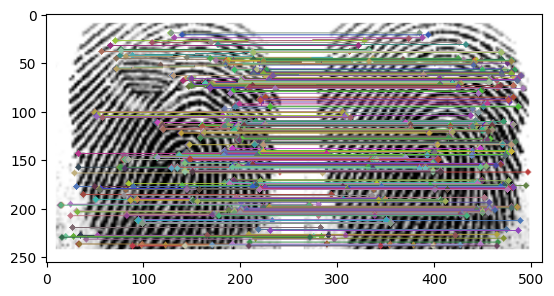

In [9]:
%%time
distances, match_score = match_finger(feat_query, feat_train, 10, flg_show=True, img_A=img_test, img_B=img_train)
print(f"distances = {distances}\nmatch score = {match_score}")

In [10]:
%%time
b_img, b_score, b_dist = find_match(img_test, list_train, 5)
print(b_img, b_score, b_dist)

100.BMP 91.91919191919192 28.363070516249607
CPU times: user 4.72 s, sys: 69.7 ms, total: 4.79 s
Wall time: 5.04 s


### 4. Prediction
- 20 images
- 1428 images

In [11]:
threshold_score = 85

In [12]:
%%time
list_test2_test = list_test2[:20]
predictions20 = []
labels20 = []

for test in tqdm(list_test2_test):
    test_img = cv2.imread(test, 0)
    pred_img, pred_score, _ = find_match(test_img, list_train, 5)
    # print(pred_score)
    if pred_score >= threshold_score:
        pred_len = len(pred_img)
        if pred_len in [5, 6, 7]:
            predictions20.append(int(pred_img[0:pred_len-4]))
        
        label = os.path.basename(test)
        label_len = len(label)
        if label_len in [11, 12, 13]:
            labels20.append(int(label[0:label_len-10]))
    else:
        predictions20.append(0)
        labels20.append(-1)

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 1min 38s, sys: 3.02 s, total: 1min 41s
Wall time: 1min 44s


In [13]:
calculateAccuracy(predictions20, labels20)

Success: 20 out of 20
Accuracy: 100.0


In [14]:
predictions = []
labels = []
scores = []

for test in tqdm(list_test2):
    test_img = cv2.imread(test, 0)
    pred_img, pred_score, _ = find_match(test_img, list_train, 5)
    scores.append(pred_score)
    
    if pred_score >= threshold_score:
        pred_len = len(pred_img)
        if pred_len in [5, 6, 7]:
            predictions.append(int(pred_img[0:pred_len-4]))
        
        label = os.path.basename(test)
        label_len = len(label)
        if label_len in [11, 12, 13]:
            labels.append(int(label[0:label_len-10]))
    else:
        predictions.append(0)
        labels.append(-1)

  0%|          | 0/1428 [00:00<?, ?it/s]

In [15]:
calculateAccuracy(predictions, labels)

Success: 1216 out of 1428
Accuracy: 85.15406162464986
